<a href="https://colab.research.google.com/github/fritzpalomo/ChangeRequest/blob/main/Transaction_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Transaction_Data.csv')

# Display basic info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_ID      5050 non-null   int64  
 1   Customer_ID         5050 non-null   int64  
 2   Transaction_Date    5050 non-null   object 
 3   Transaction_Amount  4950 non-null   float64
 4   Transaction_Type    5050 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 197.4+ KB


(None,
    Transaction_ID  Customer_ID     Transaction_Date  Transaction_Amount  \
 0               1          393  2023-01-01 00:00:00              3472.0   
 1               2          826  2023-01-01 01:00:00                 NaN   
 2               3          916  2023-01-01 02:00:00                10.0   
 3               4          109  2023-01-01 03:00:00                72.0   
 4               5          889  2023-01-01 04:00:00              1793.0   
 
   Transaction_Type  
 0         Purchase  
 1     Bill Payment  
 2         Purchase  
 3       Investment  
 4       Investment  )

In [ ]:
# Convert Transaction_Date to datetime
df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"])

# Handle missing values in Transaction_Amount (replace with median value)
df["Transaction_Amount"].fillna(df["Transaction_Amount"].median(), inplace=True)

# Encode Transaction_Type using one-hot encoding
df = pd.get_dummies(df, columns=["Transaction_Type"], prefix="Type")

# Extract time-based features
df["Year"] = df["Transaction_Date"].dt.year
df["Month"] = df["Transaction_Date"].dt.month
df["Day"] = df["Transaction_Date"].dt.day
df["Hour"] = df["Transaction_Date"].dt.hour
df["Day_of_Week"] = df["Transaction_Date"].dt.dayofweek

# Aggregate customer behavior features
customer_summary = df.groupby("Customer_ID")["Transaction_Amount"].agg(
    Total_Spent="sum", Average_Spent="mean", Transaction_Count="count"
)

# Merge customer behavior features back to main dataset
df = df.merge(customer_summary, on="Customer_ID", how="left")

# Check for duplicates and remove them
df.drop_duplicates(inplace=True)

# Display the first few rows after preprocessing
df.head()

/var/folders/s5/bxh06wfn0bs80gz6wbw_5msc0000gn/T/ipykernel_40897/404835986.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Transaction_Amount"].fillna(df["Transaction_Amount"].median(), inplace=True)


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Type_Bill Payment,Type_Investment,Type_Loan Payment,Type_Purchase,Year,Month,Day,Hour,Day_of_Week,Total_Spent,Average_Spent,Transaction_Count
0,1,393,2023-01-01 00:00:00,3472.0,False,False,False,True,2023,1,1,0,6,22365.0,3195.000000,7
1,2,826,2023-01-01 01:00:00,2483.0,True,False,False,False,2023,1,1,1,6,6929.0,2309.666667,3
2,3,916,2023-01-01 02:00:00,10.0,False,False,False,True,2023,1,1,2,6,18406.0,2045.111111,9
3,4,109,2023-01-01 03:00:00,72.0,False,True,False,False,2023,1,1,3,6,7492.0,1498.400000,5
4,5,889,2023-01-01 04:00:00,1793.0,False,True,False,False,2023,1,1,4,6,5807.0,1935.666667,3


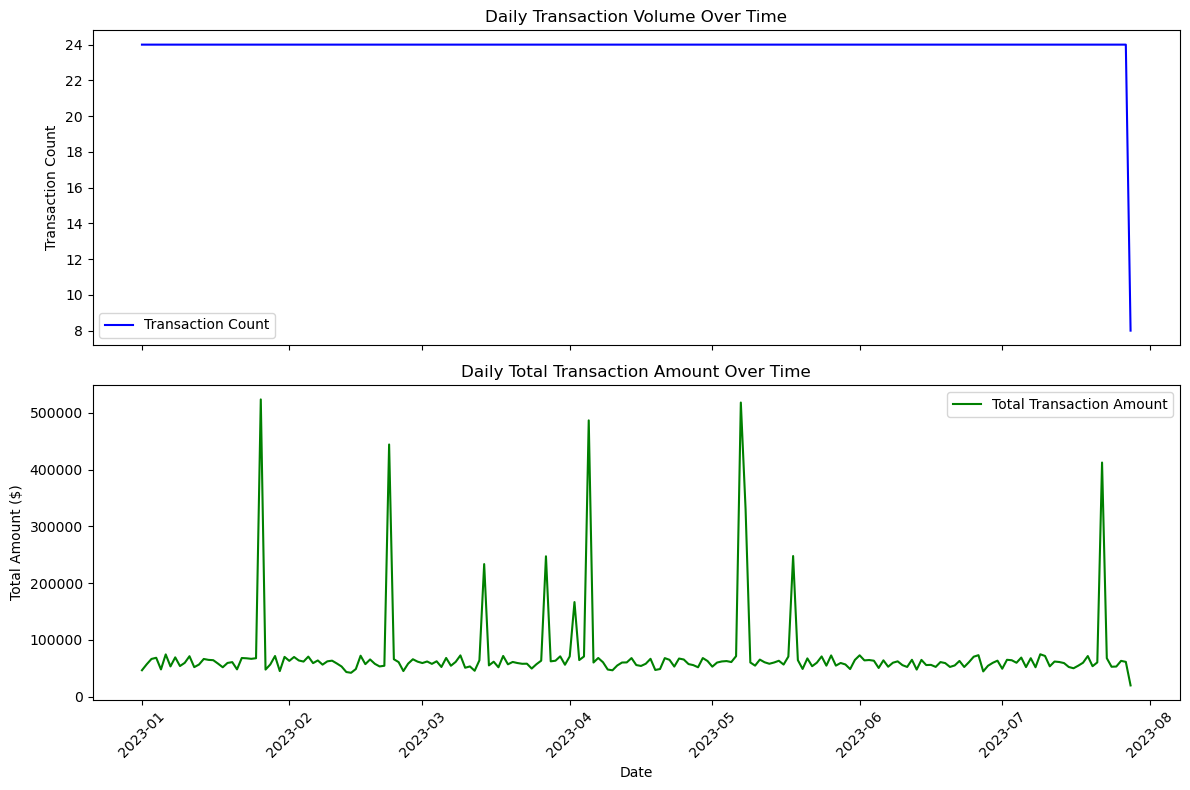

In [ ]:
import matplotlib.pyplot as plt

# Set the index to Transaction_Date for time series analysis
df.set_index("Transaction_Date", inplace=True)

# Resample data to get daily transaction count and total transaction amount
daily_trend = df.resample("D").agg({"Transaction_ID": "count", "Transaction_Amount": "sum"})
daily_trend.rename(columns={"Transaction_ID": "Transaction_Count"}, inplace=True)

# Plot Transaction Volume and Total Transaction Amount trends
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Transaction Volume Over Time
axes[0].plot(daily_trend.index, daily_trend["Transaction_Count"], color="blue", label="Transaction Count")
axes[0].set_title("Daily Transaction Volume Over Time")
axes[0].set_ylabel("Transaction Count")
axes[0].legend()

# Total Transaction Amount Over Time
axes[1].plot(daily_trend.index, daily_trend["Transaction_Amount"], color="green", label="Total Transaction Amount")
axes[1].set_title("Daily Total Transaction Amount Over Time")
axes[1].set_ylabel("Total Amount ($)")
axes[1].legend()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()